<a href="https://colab.research.google.com/github/msof07/msof07/blob/main/An%C3%A1lisis_de_Sentimiento_Encuestas_Ver_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notas para modificación

* ~~Remover el stemming para ver si mejora la calificación de la polaridad~~ (casi no hay diferencia en este caso, sample: 92)
* Cómo modificar elementos de polaridad que por contexto se entienden pero que problamente no lo sabe la herramienta
* Estos comentarios son los anotados por la escuela, el sentimiento puede ser diferente a los escritos por el mismo padre de familia, ver si hay diferencia
* ~~Cargar los scores en un nuevo dataframe~~
  * Sentiment by keyword
  * Top positive keywords
  * Top negative kewwords
  * ~~Sentiment share plot~~ *** fijarme en la suma por si hay valores negativos sino se van a restar
* Hacer en formato de función el key wordcloud y ~~la polaridad~~

## Librerías

In [1]:
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from google.colab import drive
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Word sequence raltion
from collections import Counter
from nltk.util import ngrams

# For Sentiment Analysis
from nltk. sentiment.vader import SentimentIntensityAnalyzer
from nltk import sentiment
from nltk import word_tokenize

El SSL debe estar deshabilitado de otra manera un error 'certificate verify failed' seguirá apareciendo. Debe de abrir la ventana con las librerías del nltk y descargar las requeridas. En este caso se necesita el vader_lexicon que es obligatorio para usar SentimentIntensityAnalyzer. Aunque ya se descargaron por primera vez, como no está deshabilidado saldrá el pop up cada vez.

In [2]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [3]:
# Downloads

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## Preprocesamiento

Para esta primera prueba, la data ha sido "limpiada" en sintaxis y errores gramaticales. De acuerdo con MS Office el editor indicaba una puntuación de 75%, después de las correcciones la puntuación es de 97%. La desventaja del NLPT es que no soporta el español, por lo que básicamente hay dos opciones:

1. Traducir el texto a inglés, sin embargo las ideas pueden cambiar durante este proceso entre otros problemas.
2. Usar "parches" con el cual se use el NLPT pero adapatado en el español sin embargo el soporte puede no estar adaptado completamente entre otros problemas en cuanto al código.

Tanto los errores ortográficos/sintaxis como la traducción pueden incluirse dentro del código a través de un API, como primera aproximación se alimentará con la data limpia de errores y traducida. Queda pendiente probar los parches disponibles para el español y adaptarlo al código además de automatizar la limpieza y traducción.

Aún con la data limpia, se deben realizar ciertos pasos antes para realizar el análisis:

* Tokenización, es decir, dividir el texto en frases
* Stemming, que es un método para reducir una palabra a su raíz o a un stem (ex. consult, consulting, consultant, etc)
* Lemmanization, hace el trabajo de relacionar las palabras con significados aproximados o que estén relacionadas (ex. good, better, etc)

Ambos ayudan a asignar varias palabras a una raíz común. De esa manera, estas palabras se tratan de manera similar y el modelo aprende que se pueden usar en contextos similares.

In [4]:
def preprocess(raw_text):
    
    # regex para identificar únicamente letras (en caso de que haya símbolos)
    # habría que ver si ciertos símbolos son importantes como por ejemplo ($)
    # en caso de que se hable de montos monetarios
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convierte en minúsculas and separa las palabras, ex. 'hello world' -> ['hello', 'world']
    words = letters_only_text.lower().split()

    cleaned_words = []
    lemmatizer = WordNetLemmatizer() # se puede agregar un stemmer, lemmatizer(? en particular
    
    # remover los stopwords
    stopWords = set(stopwords.words('english'))
    # hay stopwords disponibles en español o bien hacer un txt con los stopwords que quiera
    # REF: https://pythonspot.com/nltk-stop-words/
    for word in words:
        if word not in stopWords:
            cleaned_words.append(word)
    
    # stemm o lemmatise
    lem_words = []
    for word in cleaned_words:
        word = lemmatizer.lemmatize(word)   # es exactamente lo mismo para lemmatise pero con 'lemmatize' en vez de stem
        lem_words.append(word)
    
    # regresa la lista de strings
    return " ".join(lem_words)

In [5]:
test_sentence = "this is a sentence to demonstrate how the preprocessing function works...!"

preprocess(test_sentence)

'sentence demonstrate preprocessing function work'

## Load Data

In [6]:
# url ='https://github.com/msof07/rcsa_lab/blob/28989d50f3879835de97b0efe4bac81e9146fb71/comments_clean.xlsx'
# comments_df = pd.read_excel(url)

# github's raw link not working for private repositories i have to check how to concede permissions later

drive.mount("/content/gdrive")

comments_df = pd.read_excel('/content/gdrive/My Drive/Colab Notebooks/Datasets/comments_clean.xlsx')

comments_df.head()

Mounted at /content/gdrive


,Comentarios,Comentarios traducidos
0,La familia notificó que se van al Kennedy por...,The family notified that they are going to the...
1,La familia hace traslado porque solo quiere cl...,The family relocates because they only want on...
2,Sonia Villarreal avisó que ya había hecho su p...,Sonia Villarreal announced that she had alread...
3,El motivo real de la baja que tomará clases en...,The real reason for the withdrawal that he wil...
4,La familia quiere educación Montessori,The family wants Montessori education


In [7]:
comments_df['prep'] = comments_df['Comentarios traducidos'].apply(preprocess)
comments_df.head()

,Comentarios,Comentarios traducidos,prep
0,La familia notificó que se van al Kennedy por...,The family notified that they are going to the...,family notified going kennedy want ib
1,La familia hace traslado porque solo quiere cl...,The family relocates because they only want on...,family relocates want online class due pandemic
2,Sonia Villarreal avisó que ya había hecho su p...,Sonia Villarreal announced that she had alread...,sonia villarreal announced already done proces...
3,El motivo real de la baja que tomará clases en...,The real reason for the withdrawal that he wil...,real reason withdrawal take class online since...
4,La familia quiere educación Montessori,The family wants Montessori education,family want montessori education


## WordCloud

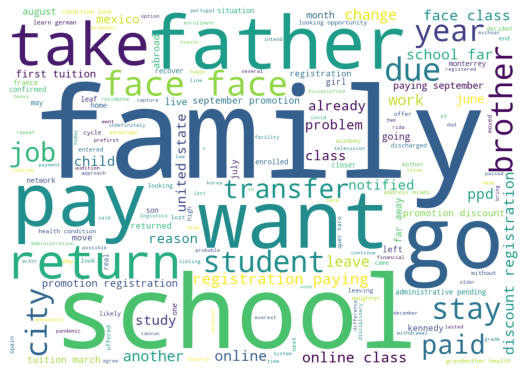

In [8]:
## CHECK THIS FUNC

def wordcloud_img(preped_df):
  all_words = '' 

  for arg in preped_df: 

      tokens = arg.split()  
        
      all_words += " ".join(tokens)+" "

  wordcloud = WordCloud(width = 1000, height = 700, 
                  background_color ='white', 
                  min_font_size = 10).generate(all_words) 
    
  # WordCloud image plot               
  plt.figure(figsize = (10, 5), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
    
  return plt.show()

wordcloud_img(comments_df['prep'])

In [11]:
Counter(" ".join(comments_df['prep']).split()).most_common(10)

[('family', 66),
 ('school', 49),
 ('face', 32),
 ('registration', 32),
 ('go', 28),
 ('class', 26),
 ('want', 24),
 ('pay', 21),
 ('father', 20),
 ('online', 18)]

In [12]:
all_words = ''
n_gram = 2
n_gram_dic = dict(Counter(ngrams(all_words.split(), n_gram)))

for i in n_gram_dic:
    if n_gram_dic[i] >= 2:
        print(i, n_gram_dic[i])

## Análisis de polaridad

* neg (negativa)
* neu (neutral)
* pos (positiva)

compound: valor entre -1 y 1 indica si la frase es positiva o negativa. Valores próximos a -1 indican que es muy negativa, próximos a cero indicarían que es neutra y próximos a 1 sería muy positiva.

In [13]:
sind = SentimentIntensityAnalyzer()

def polarity_comment(col_prep):

  negative = []
  neutral = []
  positive = []
  compound_score = []

  for comments in comments_df['prep']:
      scores = sind.polarity_scores(comments)
      for key in scores:
        if key == 'neg':
          negative.append(list(scores.values())[0])
        elif key == 'neu':
          neutral.append(list(scores.values())[1])
        elif key == 'pos':
          positive.append(list(scores.values())[2])
        elif key == 'compound':
          compound_score.append(list(scores.values())[3])

  comments_scored = comments_df.assign(neg_score=negative, neu_score=neutral, pos_score=positive, compound=compound_score)
  return comments_scored

In [14]:
sentiment_df = polarity_comment(comments_df['prep'])
sentiment_df.head()

,Comentarios,Comentarios traducidos,prep,neg_score,neu_score,pos_score,compound
0,La familia notificó que se van al Kennedy por...,The family notified that they are going to the...,family notified going kennedy want ib,0.0,0.794,0.206,0.0772
1,La familia hace traslado porque solo quiere cl...,The family relocates because they only want on...,family relocates want online class due pandemic,0.0,0.822,0.178,0.0772
2,Sonia Villarreal avisó que ya había hecho su p...,Sonia Villarreal announced that she had alread...,sonia villarreal announced already done proces...,0.0,1.000,0.000,0.0000
3,El motivo real de la baja que tomará clases en...,The real reason for the withdrawal that he wil...,real reason withdrawal take class online since...,0.0,0.789,0.211,0.1027
4,La familia quiere educación Montessori,The family wants Montessori education,family want montessori education,0.0,0.698,0.302,0.0772


In [16]:
sentiment_df.describe()

,neg_score,neu_score,pos_score,compound
count,168.000000,168.000000,168.000000,168.000000
mean,0.065155,0.865060,0.069780,0.015073
std,0.118097,0.157902,0.119412,0.190814
min,0.000000,0.417000,0.000000,-0.831600
25%,0.000000,0.744000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,0.140750,1.000000,0.139750,0.077200
max,0.583000,1.000000,0.556000,0.585900


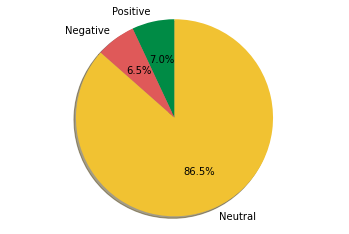

In [18]:
sum_neg = sentiment_df['neg_score'].sum()
sum_pos = sentiment_df['pos_score'].sum()
sum_neu = sentiment_df['neu_score'].sum()

labels = 'Positive', 'Negative', 'Neutral'
sizes = [sum_pos, sum_neg, sum_neu]

colors = ['#008b45','#df5959','#f1c232']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors)
ax1.axis('equal')  # aspect ratio circle.

plt.show()

## Topic Modeling

En proceso...

## De diccionario a matriz a dataframe (IGNORAR)

`polarity_scores` method devuelve los valores en forma de diccionario, debo convertirlo a una lista por cada comentario para poder agregarlo al dataframe principal

In [ ]:
for comments in comments_df['prep'][0:3]:
  scores = sind.polarity_scores(comments)
  print(comments)
  print(scores)
  for element in scores.values():
    print(element)
  #for key in scores:
    #print(key, ":", scores [key])
    #print()

In [ ]:
temp_neg = []
temp_neu = []
temp_pos = []
temp_comp = []

for comments in comments_df['prep']:
  scores = sind.polarity_scores(comments)
  for key in scores:
    if key == 'neg':
      temp_neg.append(list(scores.values())[0])
    elif key == 'neu':
      temp_neu.append(list(scores.values())[1])
    elif key == 'pos':
      temp_pos.append(list(scores.values())[2])
    elif key == 'compound':
      temp_comp.append(list(scores.values())[3])

# devuelve una lista con los scores de cada comentario
# ie. una matriz de 4 x len(comments_df)
print(temp_neg)